# Spatial Joins

A *spatial join* uses [binary predicates](http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates) 
such as `intersects` and `crosses` to combine two `GeoDataFrames` based on the spatial relationship 
between their geometries.

A common use case might be a spatial join between a point layer and a polygon layer where you want to retain the point geometries and grab the attributes of the intersecting polygons.

![illustration](https://web.natur.cuni.cz/~langhamr/lectures/vtfg1/mapinfo_1/about_gis/Image23.gif)


## Types of spatial joins

We currently support the following methods of spatial joins. We refer to the *left_df* and *right_df* which are the correspond to the two dataframes passed in as args.

### Left outer join

In a LEFT OUTER JOIN (`how='left'`), we keep *all* rows from the left and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right if they intersect and lose right rows that don't intersect. A left outer join implies that we are interested in retaining the geometries of the left. 

This is equivalent to the PostGIS query:
```
SELECT pts.geom, pts.id as ptid, polys.id as polyid  
FROM pts
LEFT OUTER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

                    geom                    | ptid | polyid 
--------------------------------------------+------+--------
 010100000040A9FBF2D88AD03F349CD47D796CE9BF |    4 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     20
 0101000000F0D88AA0E1A4EEBF7052F7E5B115E9BF |    2 |     20
 0101000000818693BA2F8FF7BF4ADD97C75604E9BF |    1 |       
(5 rows)
```

### Right outer join

In a RIGHT OUTER JOIN (`how='right'`), we keep *all* rows from the right and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the left if they intersect and lose left rows that don't intersect. A right outer join implies that we are interested in retaining the geometries of the right. 

This is equivalent to the PostGIS query:
```
SELECT polys.geom, pts.id as ptid, polys.id as polyid  
FROM pts
RIGHT OUTER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

  geom    | ptid | polyid 
----------+------+--------
 01...9BF |    4 |     10
 01...9BF |    3 |     10
 02...7BF |    3 |     20
 02...7BF |    2 |     20
 00...5BF |      |     30
(5 rows)
```

### Inner join

In an INNER JOIN (`how='inner'`), we keep rows from the right and left only where their binary predicate is `True`. We duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right and left only if they intersect and lose all rows that do not. An inner join implies that we are interested in retaining the geometries of the left. 

This is equivalent to the PostGIS query:
```
SELECT pts.geom, pts.id as ptid, polys.id as polyid  
FROM pts
INNER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

                    geom                    | ptid | polyid 
--------------------------------------------+------+--------
 010100000040A9FBF2D88AD03F349CD47D796CE9BF |    4 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     20
 0101000000F0D88AA0E1A4EEBF7052F7E5B115E9BF |    2 |     20
(4 rows) 
```

## Spatial Joins between two GeoDataFrames

Let's take a look at how we'd implement these using `GeoPandas`. First, load up the NYC test data into `GeoDataFrames`:

In [1]:
%matplotlib inline
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file

# NYC Boros
zippath = datasets.get_path('nybb')
polydf = read_file(zippath)

# Generate some points
b = [int(x) for x in polydf.total_bounds]
N = 8
pointdf = GeoDataFrame([
    {'geometry': Point(x, y), 'value1': x + y, 'value2': x - y}
    for x, y in zip(range(b[0], b[2], int((b[2] - b[0]) / N)),
                    range(b[1], b[3], int((b[3] - b[1]) / N)))])

# Make sure they're using the same projection reference
pointdf.crs = polydf.crs

In [2]:
pointdf

,geometry,value1,value2
0,POINT (913175.000 120121.000),1033296,793054
1,POINT (932450.000 139211.000),1071661,793239
2,POINT (951725.000 158301.000),1110026,793424
3,POINT (971000.000 177391.000),1148391,793609
4,POINT (990275.000 196481.000),1186756,793794
5,POINT (1009550.000 215571.000),1225121,793979
6,POINT (1028825.000 234661.000),1263486,794164
7,POINT (1048100.000 253751.000),1301851,794349
8,POINT (1067375.000 272841.000),1340216,794534


In [3]:
polydf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


<AxesSubplot:>

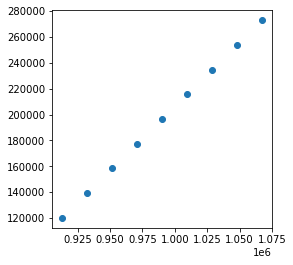

In [4]:
pointdf.plot()

<AxesSubplot:>

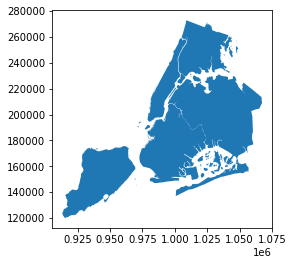

In [5]:
polydf.plot()

## Joins

In [6]:
join_left_df = pointdf.sjoin(polydf, how="left")
join_left_df
# Note the NaNs where the point did not intersect a boro

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,POINT (913175.000 120121.000),1033296,793054,NaN,NaN,NaN,NaN,NaN
1,POINT (932450.000 139211.000),1071661,793239,0.0,5.0,Staten Island,330470.010332,1.623820e+09
2,POINT (951725.000 158301.000),1110026,793424,0.0,5.0,Staten Island,330470.010332,1.623820e+09
3,POINT (971000.000 177391.000),1148391,793609,NaN,NaN,NaN,NaN,NaN
4,POINT (990275.000 196481.000),1186756,793794,NaN,NaN,NaN,NaN,NaN
5,POINT (1009550.000 215571.000),1225121,793979,1.0,4.0,Queens,896344.047763,3.045213e+09
6,POINT (1028825.000 234661.000),1263486,794164,4.0,2.0,Bronx,464392.991824,1.186925e+09
7,POINT (1048100.000 253751.000),1301851,794349,NaN,NaN,NaN,NaN,NaN
8,POINT (1067375.000 272841.000),1340216,794534,NaN,NaN,NaN,NaN,NaN


In [7]:
join_right_df = pointdf.sjoin(polydf, how="right")
join_right_df
# Note Staten Island is repeated

,index_left,value1,value2,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,1.0,1071661.0,793239.0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
0,2.0,1110026.0,793424.0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,5.0,1225121.0,793979.0,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,NaN,NaN,NaN,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,NaN,NaN,NaN,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,6.0,1263486.0,794164.0,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [8]:
join_inner_df = pointdf.sjoin(polydf, how="inner")
join_inner_df
# Note the lack of NaNs; dropped anything that didn't intersect

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
1,POINT (932450.000 139211.000),1071661,793239,0,5,Staten Island,330470.010332,1.623820e+09
2,POINT (951725.000 158301.000),1110026,793424,0,5,Staten Island,330470.010332,1.623820e+09
5,POINT (1009550.000 215571.000),1225121,793979,1,4,Queens,896344.047763,3.045213e+09
6,POINT (1028825.000 234661.000),1263486,794164,4,2,Bronx,464392.991824,1.186925e+09


We're not limited to using the `intersection` binary predicate. Any of the `Shapely` geometry methods that return a Boolean can be used by specifying the `op` kwarg.

In [9]:
pointdf.sjoin(polydf, how="left", op="within")

/opt/miniconda3/envs/geopandas_docs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,POINT (913175.000 120121.000),1033296,793054,NaN,NaN,NaN,NaN,NaN
1,POINT (932450.000 139211.000),1071661,793239,0.0,5.0,Staten Island,330470.010332,1.623820e+09
2,POINT (951725.000 158301.000),1110026,793424,0.0,5.0,Staten Island,330470.010332,1.623820e+09
3,POINT (971000.000 177391.000),1148391,793609,NaN,NaN,NaN,NaN,NaN
4,POINT (990275.000 196481.000),1186756,793794,NaN,NaN,NaN,NaN,NaN
5,POINT (1009550.000 215571.000),1225121,793979,1.0,4.0,Queens,896344.047763,3.045213e+09
6,POINT (1028825.000 234661.000),1263486,794164,4.0,2.0,Bronx,464392.991824,1.186925e+09
7,POINT (1048100.000 253751.000),1301851,794349,NaN,NaN,NaN,NaN,NaN
8,POINT (1067375.000 272841.000),1340216,794534,NaN,NaN,NaN,NaN,NaN
